In [2]:
import numpy as np
import pygam

In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

In [6]:
import switch_metrics as sm
res = sm.add_switch_metrics_wrapper(data_dir_full,
                        dosave=False, save_dir='switch_analysis',save_fn='all_switch_info.p',
                        force_reload=False,
                        load_only=True)
plt.close()
spk_beh_df=res['spk_beh_df']
trial_index_to_index_within_trialtype= dpp.trial_index_to_index_within_trialtype(spk_beh_df)
cell_cols_d=res['cell_cols_d']
fr_map_trial_df_d=res['fr_map_trial_df_d']
all_sw_info=res['all_sw_info']
pf_all_field_combined = res['pf_all_field_combined']
changes_df_combined = res['changes_df_combined']


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_switch_info.p exists; loading---


In [200]:
from pygam import s,l,f,te

In [137]:
import gam_analysis as ga
reload(ga)
load_res=ga.load_data(data_dir_full)
prep_res=ga.prep_data(load_res,task_ind=0)
spk_beh_df_binned = prep_res['spk_beh_df_binned']

cant format into a dataframe
cant format into a dataframe


/mnt/home/szheng/projects/util_code/gam_analysis.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdb.set_trace()


NameError: name 'prep_regression' is not defined

In [277]:
def fit_gam(y):
    gam = PoissonGAM(te(0,f(1)),lam=[0.001,0]).fit(X,y)
    return gam

In [297]:
uid_l = cell_cols_d['pyr'][:40]
y_l = []
for uid in uid_l:

    X,y = ga.prep_regression(spk_beh_df_binned,uid,['lin','visitedArm'])
    y_l.append(y)
Y = np.array(y_l).T


In [292]:
from joblib import Parallel, delayed

In [298]:
%%time
n_jobs = -1  # Use all available CPU cores
gams = Parallel(n_jobs=n_jobs)(delayed(fit_gam)(y) for y in Y.T)


CPU times: user 65.7 ms, sys: 4.66 ms, total: 70.3 ms
Wall time: 5.88 s


In [300]:
gam_d = {uid:gam for uid,gam in zip(uid_l, gams)}

In [299]:
%%time
gam_d = {}
for uid in uid_l:

    X,y = ga.prep_regression(spk_beh_df_binned,uid,['lin','visitedArm'])
    gam = PoissonGAM(te(0,f(1)),lam=[0.001,0]).fit(X,y)
    gam_d[uid] = gam

CPU times: user 39.6 s, sys: 20.7 s, total: 1min
Wall time: 15.1 s


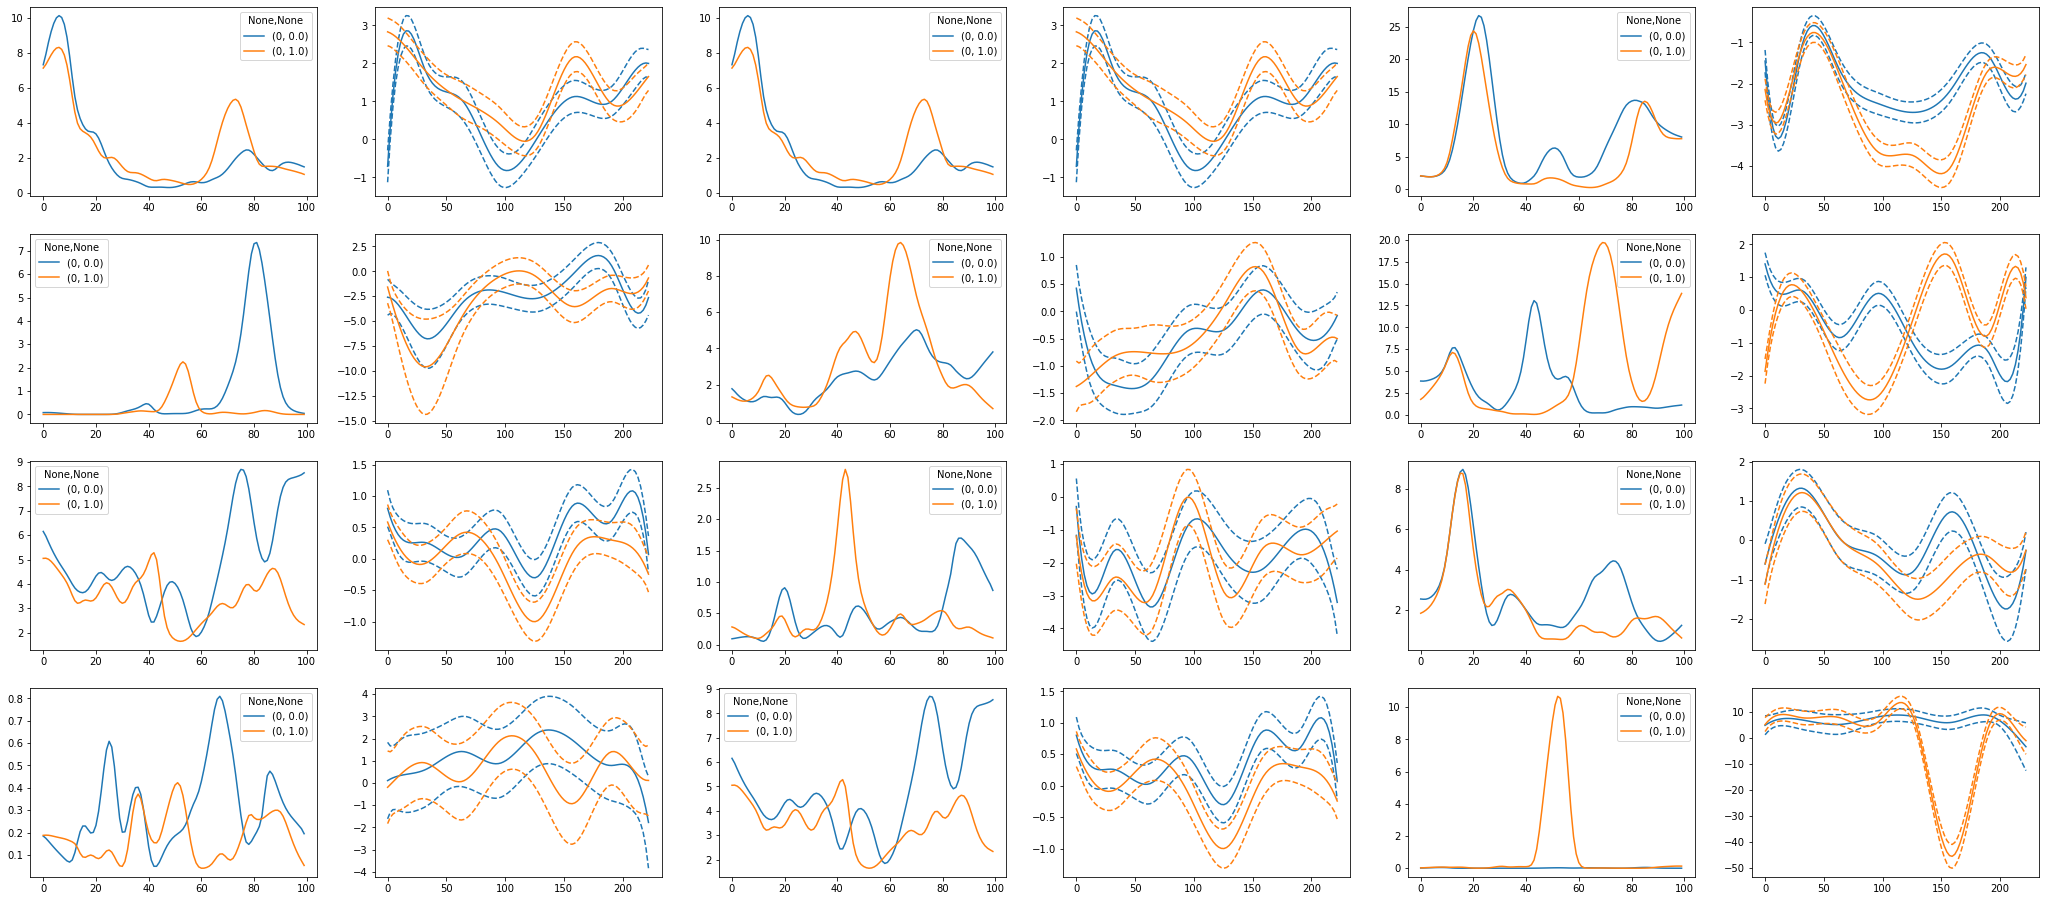

In [301]:
lin = X[:,0]
trialtype = X[:,1]

n_uid = 12
uid_selected = np.random.choice(uid_l,n_uid)
nplots = n_uid*2
fig,axs = ph.subplots_wrapper(nplots)
for ii,uid in enumerate(uid_selected):
    gam = gam_d[uid]
    ax = axs.ravel()[ii*2]
    fr_map_trial_df_d.mean(axis=1).loc[slice(None),slice(None),uid].unstack().T.plot(ax=ax)
    
    ax = axs.ravel()[ii*2+1]
    ga.plot_lin_dependence_by_trialtype(gam,lin,trialtype,fig=fig,ax=ax,n_grid=100)
    

<AxesSubplot:>

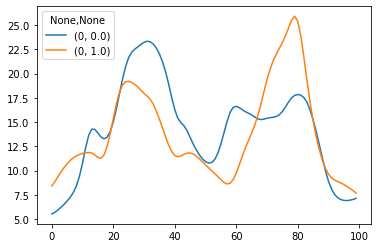

In [271]:
fr_map_trial_df_d.mean(axis=1).loc[slice(None),slice(None),uid].unstack().T.plot()

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

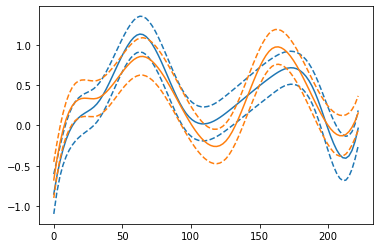

In [272]:
reload(ga)
lin = X[:,0]
trialtype = X[:,1]
ga.plot_lin_dependence_by_trialtype(gam,lin,trialtype,fig=None,ax=None,n_grid=100)

In [269]:
lam = list(np.logspace(-6, 3, 4))
# lams = [lam] * (len(gam.terms)-1)
lams = [lam] 

gam.gridsearch(X, y, lam=lam)
gam.summary()

100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     19.9794
Link Function:                          LogLink Log Likelihood:                                -36244.8717
Number of Samples:                        32287 AIC:                                            72529.7022
                                                AICc:                                           72529.7308
                                                UBRE:                                               3.2916
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0631
Feature Function                  Lam

/tmp/ipykernel_781944/2627895406.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [185]:
gam.terms

te(0, 1) + intercept

In [136]:
spk_beh_df_binned = load_res['spk_beh_df_binned']

,1,2,3,4,5,6,7,8,9,10,...,trial,task_index,task,speed,speed_kalman,visitedArm,correct,v,trial_type,lin_binned
Time (s),,,,,,,,,,,,,,,,,,,,,
7865.562433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,alternation,3.221889,2.650960,1.0,NaN,NaN,"(0, 1.0)",0
7865.629100,0.0,0.0,0.0,5.0,6.0,6.0,4.0,2.0,0.0,1.0,...,0.0,0,alternation,3.346746,2.641724,1.0,NaN,NaN,"(0, 1.0)",0
7865.695800,0.0,0.0,0.0,3.0,5.0,6.0,2.0,1.0,1.0,0.0,...,0.0,0,alternation,3.466216,2.607418,1.0,NaN,NaN,"(0, 1.0)",99
7865.762467,0.0,0.0,0.0,4.0,7.0,1.0,3.0,2.0,3.0,3.0,...,0.0,0,alternation,3.579526,2.831861,1.0,NaN,NaN,"(0, 1.0)",99
7865.829167,1.0,0.0,0.0,7.0,7.0,4.0,3.0,3.0,3.0,4.0,...,0.0,0,alternation,3.685936,3.604755,1.0,NaN,NaN,"(0, 1.0)",99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10017.372600,0.0,0.0,0.0,4.0,2.0,1.0,3.0,5.0,1.0,2.0,...,69.0,0,alternation,0.150965,0.659704,1.0,1.0,NaN,"(0, 1.0)",97
10017.439267,0.0,0.0,0.0,2.0,0.0,4.0,0.0,3.0,2.0,0.0,...,69.0,0,alternation,0.121089,0.128703,1.0,1.0,NaN,"(0, 1.0)",97
10017.505967,0.0,0.0,0.0,4.0,1.0,0.0,0.0,3.0,4.0,3.0,...,69.0,0,alternation,0.091026,0.500140,1.0,1.0,NaN,"(0, 1.0)",97


In [26]:
spk_beh_df_rebinned=spk_beh_df[cell_cols_d['pyr']].rolling(3).sum()[::3].dropna(axis=0,how='all')

In [17]:
from pygam import PoissonGAM,s

In [58]:
ma=~np.isnan(x).any(axis=1)

In [120]:
# Fit the Poisson GAM
uid = 55
x =spk_beh_df.loc[spk_beh_df_rebinned.index][['lin','v']].values
ma=~np.isnan(x).any(axis=1)
y =spk_beh_df_rebinned[uid].values
x = x[ma]
y = y[ma]
gam = PoissonGAM(s(0)+s(1)).fit(x, y)
# gam_by = PoissonGAM(s(0,by=1)).fit(x, y)


In [121]:
gam_te = PoissonGAM(te(0,1)).fit(x, y)

In [123]:
x0 = x[:,0]
x1=x[:,1]

In [124]:
# Generate grid for both predictor variables
x0_grid = np.linspace(x0.min(), x0.max(), 100)
x1_grid = np.linspace(x1.min(), x1.max(), 100)
xx0, xx1 = np.meshgrid(x0_grid, x1_grid)
X_grid = np.c_[xx0.ravel(), xx1.ravel()]

# Calculate partial dependence
pd_by, _ = gam_by.partial_dependence(term=0,X=X_grid, width=0.95)
pd_by_2d = pd_by.reshape(xx0.shape)

pd_te, _ = gam_te.partial_dependence(term=0,X=X_grid, width=0.95)
pd_te_2d = pd_te.reshape(xx0.shape)


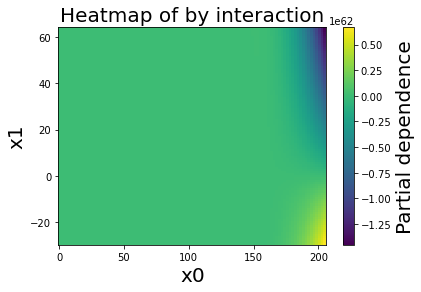

In [125]:
plt.figure()
plt.pcolormesh(xx0, xx1, pd_by_2d, cmap='viridis')
plt.colorbar(label='Partial dependence')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Heatmap of by interaction')
plt.show()

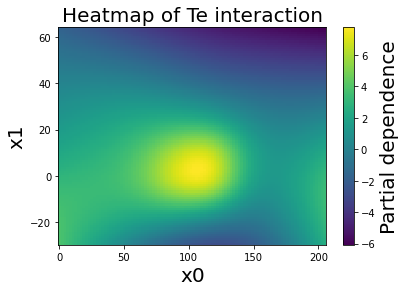

In [126]:
plt.figure()
plt.pcolormesh(xx0, xx1, pd_te_2d, cmap='viridis')
plt.colorbar(label='Partial dependence')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Heatmap of Te interaction')
plt.show()

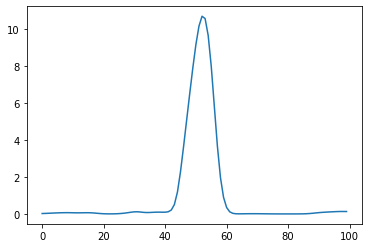

In [128]:
%matplotlib inline
plt.plot(fr_map_trial_df_d.loc[0,1,uid].T.mean(axis=0))

In [92]:
gam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     20.2953
Link Function:                          LogLink Log Likelihood:                                -33210.8861
Number of Samples:                        20233 AIC:                                            66462.3629
                                                AICc:                                           66462.4099
                                                UBRE:                                               3.6431
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0921
Feature Function                  Lam

/tmp/ipykernel_781944/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [36]:
x

array([  0.        , 221.03331358, 219.80298541, ..., 216.46352323,
       215.49683681, 214.61803098])

In [71]:
XX

(array([-29.25554409, -28.31663791, -27.37773172, -26.43882554,
        -25.49991935, -24.56101317, -23.62210699, -22.6832008 ,
        -21.74429462, -20.80538843, -19.86648225, -18.92757606,
        -17.98866988, -17.04976369, -16.11085751, -15.17195133,
        -14.23304514, -13.29413896, -12.35523277, -11.41632659,
        -10.4774204 ,  -9.53851422,  -8.59960803,  -7.66070185,
         -6.72179567,  -5.78288948,  -4.8439833 ,  -3.90507711,
         -2.96617093,  -2.02726474,  -1.08835856,  -0.14945238,
          0.78945381,   1.72835999,   2.66726618,   3.60617236,
          4.54507855,   5.48398473,   6.42289092,   7.3617971 ,
          8.30070328,   9.23960947,  10.17851565,  11.11742184,
         12.05632802,  12.99523421,  13.93414039,  14.87304658,
         15.81195276,  16.75085894,  17.68976513,  18.62867131,
         19.5675775 ,  20.50648368,  21.44538987,  22.38429605,
         23.32320224,  24.26210842,  25.2010146 ,  26.13992079,
         27.07882697,  28.01773316,  28.

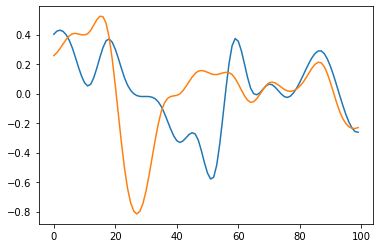

In [83]:
plt.figure()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))

In [84]:
from pygam import PoissonGAM, s, te
from pygam.datasets import chicago

X, y = chicago(return_X_y=True)

gam = PoissonGAM(s(0, n_splines=200) + te(3, 1) + s(2)).fit(X, y)

In [88]:
X.shape

(4863, 4)

<IPython.core.display.Javascript object>


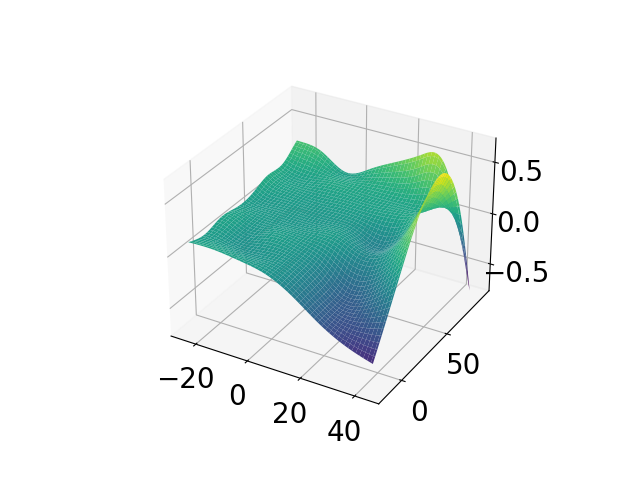

In [86]:
%matplotlib notebook
XX = gam.generate_X_grid(term=1, meshgrid=True)
Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')



IndexError: tuple index out of range

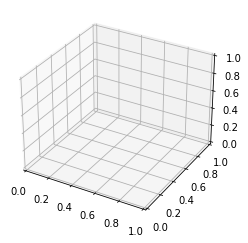

In [82]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

plt.ion()
XX = gam.generate_X_grid(term=1, meshgrid=True)
Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')


ValueError: x and y must be the same size

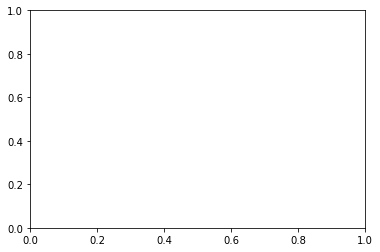

In [67]:
# Make predictions
y_pred = gam.predict(x)
y_pred_conf_ints = gam.confidence_intervals(x, width=0.95)

# Plot the true function, observations, and fitted curve
plt.figure()
# plt.plot(x, y_true, color='gray', label='True function')
plt.scatter(x, y, color='blue', alpha=0.5, label='Observations')
plt.scatter(x, y_pred, color='red', label='Fitted curve')
# plt.fill_between(x, y_pred_conf_ints[:, 0], y_pred_conf_ints[:, 1], color='red', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


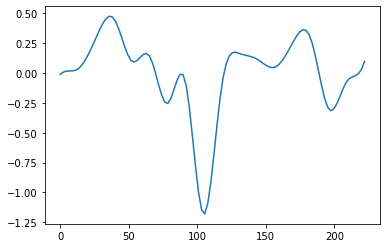

In [48]:
x_grid = np.linspace(x.min(),x.max(),100)
y_func=gam.partial_dependence(term=0, X=x_grid)
plt.plot(x_grid,y_func)

In [13]:
spk_beh_df_rebinned[5]

Time (s)
7865.662433      9.0
7865.762467      9.0
7865.862500      9.0
7865.962533     17.0
7866.062567     19.0
                ... 
10017.272567     4.0
10017.372600     2.0
10017.472600     1.0
10017.572633     5.0
10017.672667     7.0
Name: 5, Length: 21525, dtype: float64